In [19]:
import importlib

import numpy as np
from matplotlib import pyplot as plt

from analysis import session, acr_sess_analys
from sess_util import sess_gen_util, sess_ntuple_util
from util import gen_util, math_util

importlib.reload(acr_sess_analys)

<module 'analysis.acr_sess_analys' from '/home/colleen/Documents/AIBS_Analysis/analysis/acr_sess_analys.py'>

In [8]:
datadir = '../data/AIBS'
sessid = 758519303

In [9]:
sess = session.Session(datadir, sessid, runtype='prod')
sess.extract_sess_attribs()
sess.extract_info()


Loading stimulus dictionary...
Loading alignment dataframe...
    NOTE: Stimulus alignment pickle already exists in ../data/AIBS/prod/mouse_408021/ophys_session_758519303
Loading sync h5 info...
Creating stimulus objects...
Loading ROI trace info...


In [22]:
print(item_percs)

[18.  22.3  0.   0.   9.6  5.1 10.5  1.4  6.4  1.1  6.8  2.8 17.6  1.3
  4.4  7.   0.   0.2  0.3 11.6  4.5  3.8  8.3  0.2  0.7  1.8  0.   0.
  0.  36.1  7.3 19.6  4.3 10.5  2.6  0.1 41.2  5.2  9.5 20.9 11.5  0.
 17.3  0.  26.2  0.6 10.2  8.2 24.7  5.6 10.9 44.8  0.3 15.5  2.1 11.4
  0.2 31.6 11.4  0.1 12.3  5.8 11.7 50.3  0.5  0.7  8.2 49.5 12.3 65.1
 15.9 23.7 80.6  0.1 29.5 11.9 20.4  2.5  4.8  7.8  7.9 15.4  1.9  0.4
  6.9  0.1  0.   1.6 52.1  5.  14.4 52.5 27.6  4.8  4.2 11.6]


In [20]:
# SELECTIVITY INDEX
analyspar = sess_ntuple_util.init_analyspar()
stimpar = sess_ntuple_util.init_stimpar(stimtype='gabors')
item_idxs, item_percs = acr_sess_analys.surp_idx_by_sess(sess, analyspar, stimpar)

(array([52., 22.,  8.,  5.,  1.,  2.,  4.,  0.,  1.,  1.]),
 array([ 0.  ,  8.06, 16.12, 24.18, 32.24, 40.3 , 48.36, 56.42, 64.48,
        72.54, 80.6 ]),
 <a list of 10 Patch objects>)

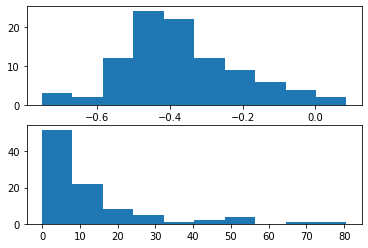

In [23]:
fig, ax = plt.subplots(2)
ax[0].hist(item_idxs)
ax[1].hist(item_percs)

In [25]:
# EVOLUTION OF E response compared to D response
# gabors
stim = sess.get_stim('gabors')
data = []
for s in [0, 1]:
    segs = stim.get_segs_by_criteria(gabfr=3, surp=1, by='seg')
    # remove consecutive
    segs = gen_util.consec(segs, smallest=True)[0]
    if s == 0:
        segs = [seg - 4 for seg in segs]
    twop_fr = stim.get_twop_fr_by_seg(segs, first=True)['first_twop_fr']
    data.append(gen_util.reshape_df_data(stim.get_roi_data(
        twop_fr, pre=0, post=0.45, integ=False, stand=True), squeeze_cols=True))
    data[-1] = math_util.integ(data[-1], 1./sess.twop_fps, axis=-1, nanpol='omit')
diff_data = data[1] - data[0]

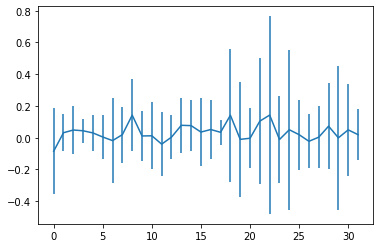

In [26]:
fig, ax = plt.subplots(1)
_ = ax.errorbar(range(diff_data.shape[1]), np.mean(diff_data, axis=0), 
    np.std(diff_data, axis=0))